##  Challenge: make your own regression model
In this notebook, I am going to take the data from 2.4.2 and run a multivariable regression model on it. I am then going to make some features and rerun the model to see if it improves. My goal here is specifically on prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
#data import
da = pd.read_csv(r'C:\Users\jmfra\OneDrive\Documents\Thinkful Data Science Files\2.4.2 drill data\table8.csv')
da.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Unnamed: 13
0,Adams Village,"1,861",0,0.000,nan,0,0,0,12,2,10,0,0.000,nan
1,Addison Town and Village,"2,577",3,0.000,nan,0,0,3,24,3,20,1,0.000,nan
2,Akron Village,"2,846",3,0.000,nan,0,0,3,16,1,15,0,0.000,nan
3,Albany,"97,956",791,8.000,nan,30,227,526,"4,090",705,"3,243",142,nan,nan
4,Albion Village,"6,388",23,0.000,nan,3,4,16,223,53,165,5,nan,nan


In [3]:
#first we need to fill in Nan values with 0 to avoid errors and get rid of the
#empty rows at the bottom
da.fillna(value=0)
da = da[0:348]
print(da.head())

                       City Population Violent\ncrime  \
0             Adams Village      1,861              0   
1  Addison Town and Village      2,577              3   
2             Akron Village      2,846              3   
3                    Albany     97,956            791   
4            Albion Village      6,388             23   

   Murder and\nnonnegligent\nmanslaughter  Rape\n(revised\ndefinition)1  \
0                                   0.000                           nan   
1                                   0.000                           nan   
2                                   0.000                           nan   
3                                   8.000                           nan   
4                                   0.000                           nan   

  Rape\n(legacy\ndefinition)2 Robbery Aggravated\nassault Property\ncrime  \
0                           0       0                   0              12   
1                           0       0               

In [4]:
#Using print shows that the column names are not straight forward so let's
#edit them all, add them to a new dataframe and leave out the unnecessary
#columns
dp = []
dp = da[['Population']]
dp['Violent_Crime'] = da[['Violent\ncrime']]
dp['Murder'] = da[['Murder and\nnonnegligent\nmanslaughter']]
dp['Rape'] = da[['Rape\n(legacy\ndefinition)2']]
dp['Robbery'] = da[['Robbery']]
dp['Burglary'] = da[['Burglary']]
dp['Aggravated_Assault'] = da[['Aggravated\nassault']]
dp['Larceny_Theft'] = da[['Larceny-\ntheft']]
dp['Motor_Vehicle_Theft'] = da[['Motor\nvehicle\ntheft']]
dp['Arson'] = da[['Arson3']]
dp['Property_Crime'] = da[['Property\ncrime']]

c:\users\jmfra\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\jmfra\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\jmfra\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [5]:
dp.head()

,Population,Violent_Crime,Murder,Rape,Robbery,Burglary,Aggravated_Assault,Larceny_Theft,Motor_Vehicle_Theft,Arson,Property_Crime
0,"1,861",0,0.000,0,0,2,0,10,0,0.000,12
1,"2,577",3,0.000,0,0,3,3,20,1,0.000,24
2,"2,846",3,0.000,0,0,1,3,15,0,0.000,16
3,"97,956",791,8.000,30,227,705,526,"3,243",142,nan,"4,090"
4,"6,388",23,0.000,3,4,53,16,165,5,nan,223


In [6]:
#looking at the new dataframe, some of the columns are not in the same in the
#format we want. Let's get rid of unnecessary characters, replace the nans 
#with 0s and convert strings to integers 
dp['Arson'] = dp['Arson'].astype(str)
dp['Population'] = dp.Population.str.replace(',','')
dp['Violent_Crime'] = dp.Violent_Crime.str.replace(',','')
dp['Rape'] = dp.Rape.str.replace(',','')
dp['Robbery'] = dp.Robbery.str.replace(',','')
dp['Burglary'] = dp.Burglary.str.replace(',','')
dp['Aggravated_Assault'] = dp.Aggravated_Assault.str.replace(',','')
dp['Larceny_Theft'] = dp.Larceny_Theft.str.replace(',','')
dp['Motor_Vehicle_Theft'] = dp.Motor_Vehicle_Theft.str.replace(',','')
dp['Arson'] = dp.Arson.str.replace('nan','0')
dp['Property_Crime'] = dp.Property_Crime.str.replace(',','')

c:\users\jmfra\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\users\jmfra\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
c:\users\jmfra\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [7]:
dp['Population'] = pd.to_numeric(dp['Population'])
dp['Violent_Crime'] = pd.to_numeric(dp['Violent_Crime'])
dp['Rape'] = pd.to_numeric(dp['Rape'])
dp['Robbery'] = pd.to_numeric(dp['Robbery'])
dp['Burglary'] = pd.to_numeric(dp['Burglary'])
dp['Aggravated_Assault'] = pd.to_numeric(dp['Aggravated_Assault'])
dp['Larceny_Theft'] = pd.to_numeric(dp['Larceny_Theft'])
dp['Motor_Vehicle_Theft'] = pd.to_numeric(dp['Motor_Vehicle_Theft'])
dp['Arson'] = pd.to_numeric(dp['Arson'])
dp['Property_Crime'] = pd.to_numeric(dp['Property_Crime'])

c:\users\jmfra\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\jmfra\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\jmfra\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [8]:
dp.head()

,Population,Violent_Crime,Murder,Rape,Robbery,Burglary,Aggravated_Assault,Larceny_Theft,Motor_Vehicle_Theft,Arson,Property_Crime
0,1861,0,0.000,0,0,2,0,10,0,0.000,12
1,2577,3,0.000,0,0,3,3,20,1,0.000,24
2,2846,3,0.000,0,0,1,3,15,0,0.000,16
3,97956,791,8.000,30,227,705,526,3243,142,0.000,4090
4,6388,23,0.000,3,4,53,16,165,5,0.000,223


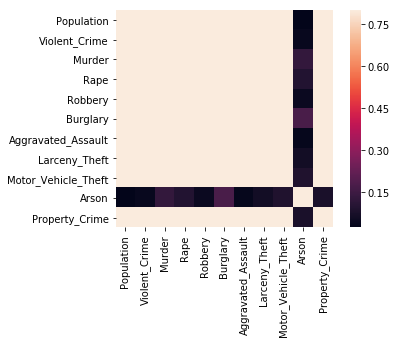

In [9]:
#the first step in linear regression is to try and identify a relationship
#between all the dependent variables and the indepedent one
corrmat = dp.corr()
f, ax = plt.subplots()
sns.heatmap(corrmat, vmax = .8, square=True)
plt.show()

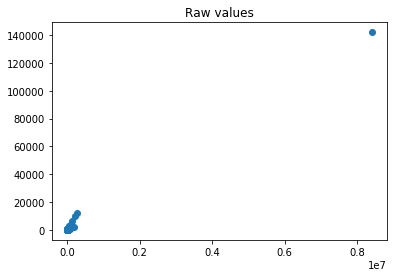

In [10]:
#This table looks too good to be true, so let us get rid of the obvious abnormality, Arson, and take a look at the rest of the
#data
dp = dp.drop(['Arson'], axis=1)
plt.scatter(dp['Population'], dp['Property_Crime'])
plt.title('Raw values')
plt.show()

In [11]:
#there is an obvious outlier so lets delete it and replot
dp[dp['Population'] > 100000]['Population']

7       118296
35      258789
216    8396126
272     210562
310     143834
346     199134
Name: Population, dtype: int64

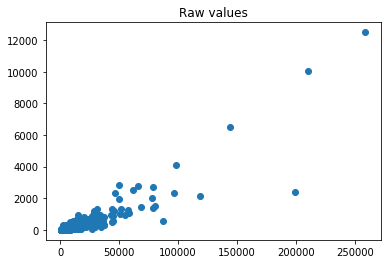

In [12]:
dp = dp.drop([216])
plt.scatter(dp['Population'], dp['Property_Crime'])
plt.title('Raw values')
plt.show()

In [13]:
#again the point at ~200000 seems to be way off in the relationship so lets delete it and move on
dp = dp.drop([346])

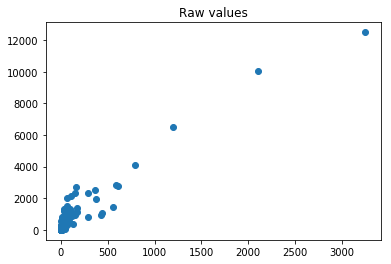

In [14]:
plt.scatter(dp['Violent_Crime'], dp['Property_Crime'])
plt.title('Raw values')
plt.show()

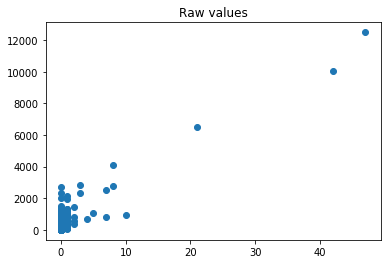

In [15]:
plt.scatter(dp['Murder'], dp['Property_Crime'])
plt.title('Raw values')
plt.show()

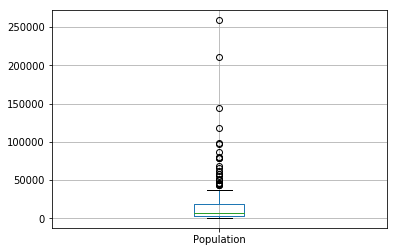

In [16]:
#We seem to be getting a reoccuring theme of a large amount of points in the bottom 20% of the graph and then a handful of 
#outliers. Lets print a boxplot, get rid of them all, and see if these graphs improve
dp.boxplot(column = 'Population')

(-50, 50000)

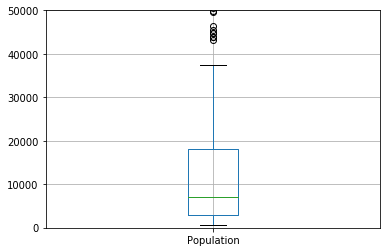

In [17]:
#zoom in 
dp.boxplot(column = 'Population')
plt.ylim(-50, 50000)

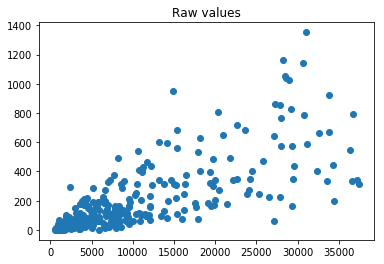

In [18]:
ds = dp[dp['Population'] < 40000]
plt.scatter(ds['Population'], ds['Property_Crime'])
plt.title('Raw values')
plt.show()

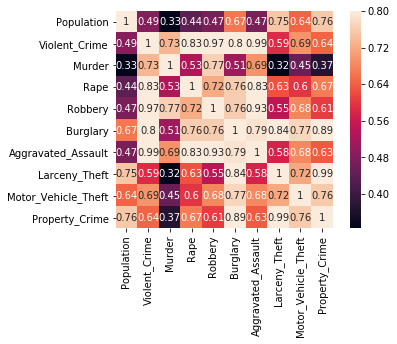

In [19]:
#We can see a roughly linear relationship, so lets redo the heatmap 
sns.heatmap(ds.corr(), vmax = .8, square=True, annot=True)


Coefficients: 
 [[ 1.  1.  1.]]

Intercept: 
 [ -8.52651283e-14]

R-squared:
1.0


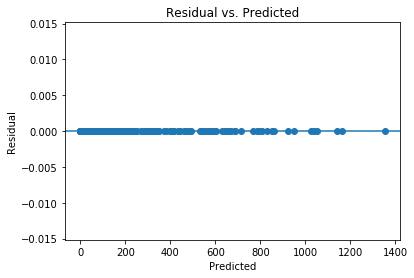

In [20]:
#This heatmap looks way better. Now we are going to want to do a regression
#we will use only the three highest correlations: burglary, larceny theft, and 
#motor vehicle theft
regr = linear_model.LinearRegression()
Y = ds['Property_Crime'].values.reshape(-1, 1)
X = ds[['Burglary','Larceny_Theft','Motor_Vehicle_Theft']]
regr.fit(X, Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

predicted = regr.predict(X).ravel()
actual = ds['Property_Crime']
residual = actual - predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [21]:
#From this regression we have found out something. Property crime is = burglary + larceny theft + motor vehicale theft
#Running a regression on this does not help us predict anything, so lets get rid of these and try again
ds = ds.drop(['Burglary'], axis=1)
ds = ds.drop(['Larceny_Theft'], axis=1)
ds = ds.drop(['Motor_Vehicle_Theft'], axis=1)

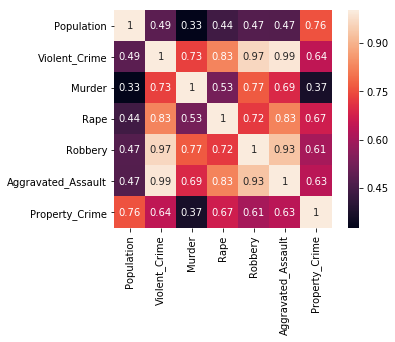

In [22]:
sns.heatmap(ds.corr(), square=True, annot=True)


Coefficients: 
 [[  1.40717019e-02  -6.11237024e+01   9.40812355e+01   6.58999784e+01
    6.05462881e+01]]

Intercept: 
 [ 9.03688234]

R-squared:
0.724280727923


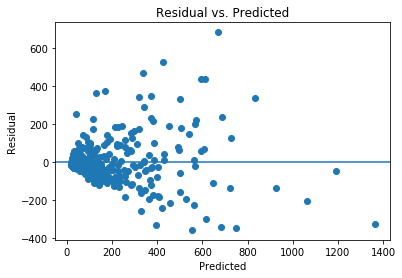

In [23]:
#here murder is the obvious outlier, while all the others have correlation in between .6 and .8
#so lets rerun the regression on all the other variables
regr = linear_model.LinearRegression()
Y = ds['Property_Crime'].values.reshape(-1, 1)
X = ds[['Population', 'Violent_Crime', 'Rape', 'Robbery', 'Aggravated_Assault']]
regr.fit(X, Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

predicted = regr.predict(X).ravel()
actual = ds['Property_Crime']
residual = actual - predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

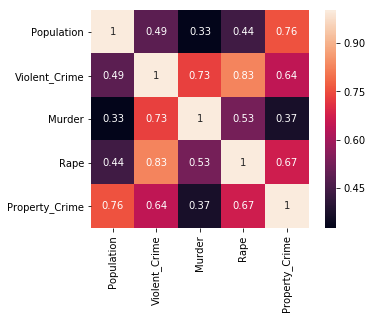

In [24]:
#This r squared value is pretty bad so lets see if we can do any transformations
#The most obvious analysis is that violent crime, aggravated assault and robbery
#have above a 93% correlation. Since violent crime is the most correlated to
#the two other options, we are going to get rid of the other two
ds = ds.drop(['Robbery'], axis=1)
ds = ds.drop(['Aggravated_Assault'], axis=1)
sns.heatmap(ds.corr(), square=True, annot=True)

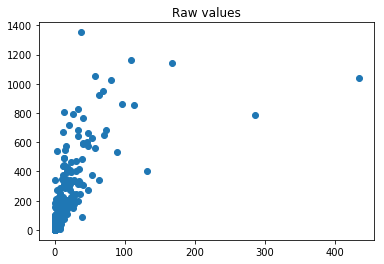

In [25]:
#from an earlier scatter plot, population and property crime are roughly
#linearly correlated, but lets look at the other two variables
plt.scatter(ds['Violent_Crime'], ds['Property_Crime'])
plt.title('Raw values')
plt.show()

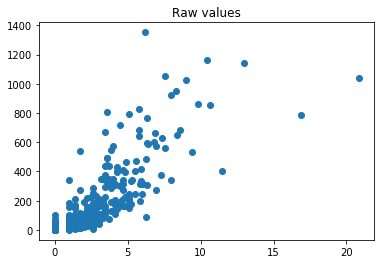

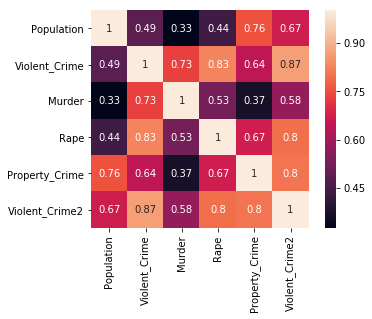

In [26]:
ds['Violent_Crime2'] = ds['Violent_Crime']**.5
plt.scatter(ds['Violent_Crime2'], ds['Property_Crime'])
plt.title('Raw values')
plt.show()
sns.heatmap(ds.corr(), square=True, annot=True)

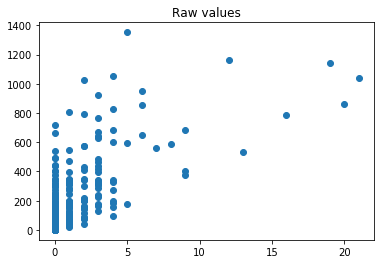

In [27]:
#taking the square root of violent crime seems to draw a much more linear 
#conclusion and improves the correlation by .16
plt.scatter(ds['Rape'], ds['Property_Crime'])
plt.title('Raw values')
plt.show()

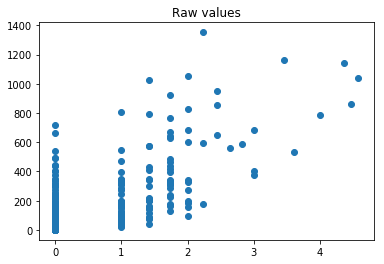

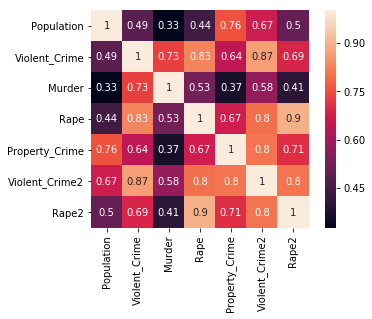

In [30]:
ds['Rape2'] = ds['Rape']**.5
plt.scatter(ds['Rape2'], ds['Property_Crime'])
plt.title('Raw values')
plt.show()
sns.heatmap(ds.corr(), square=True, annot=True)


Coefficients: 
 [[  1.04200734e-02   3.29520507e+01   5.34614333e+01]]

Intercept: 
 [-36.06448493]

R-squared:
0.748011944478


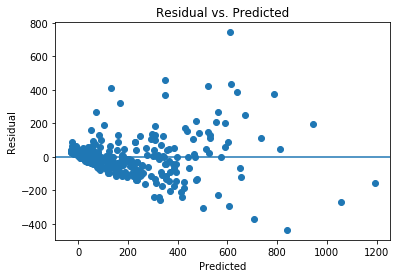

In [29]:
#just like violent crime, rape looks more linear after this transformation 
#and improves correlation. now lets rerun the regression
regr = linear_model.LinearRegression()
Y = ds['Property_Crime'].values.reshape(-1, 1)
X = ds[['Population', 'Violent_Crime2', 'Rape2']]
regr.fit(X, Y)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

predicted = regr.predict(X).ravel()
actual = ds['Property_Crime']
residual = actual - predicted
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Looks like grouping a few variables and transforming the others did improve the r^2, but not by much. The problem is that the residual actually looks worse, with higher varaince and way more residuals below 0, but higher variance above. The issue with this set is in its collection. There is a large majority of neighborhoods with low populations and a handful of populations well above the average. The non-normality makes it so we can not perform a lot of transformations to the data.